In [1]:
!pip install kaggle

In [2]:
import os

# Create the .kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file to the .kaggle directory
!mv kaggle.json /root/.kaggle/


In [3]:
!chmod 600 /root/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d adityajn105/flickr8k


 99% 1.02G/1.04G [00:07<00:00, 204MB/s]
100% 1.04G/1.04G [00:07<00:00, 142MB/s]


In [5]:
!unzip -q flickr8k.zip -d flickr8k

In [6]:
import numpy as np
import pickle
import os
from tqdm.notebook import tqdm #completion estimation

import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16 #extrat features from images
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [7]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content'


In [8]:
# loading model
model = VGG16()
#restructing model
model = Model(inputs = model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [9]:
# creating dictionary for image features

features ={}
directory = os.path.join(BASE_DIR,'Images')

for img_name in tqdm(os.listdir(directory)):
  img_path = directory + '/' +img_name   #load the image from file
  image = load_img(img_path,target_size=(224,224))

  image = img_to_array(image)
  image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))

  image = preprocess_input(image)

  feature = model.predict(image,verbose=0)

  img_id = img_name.split('.')[0]

  features[img_id] =feature


  0%|          | 0/8091 [00:00<?, ?it/s]

In [10]:
len(features)

8091

In [11]:
#store features
pickle.dump(features , open(os.path.join(WORKING_DIR , 'feature.pkl' ),'wb'))

In [12]:
#load features
with open(os.path.join(WORKING_DIR , 'feature.pkl') ,'rb') as f :
  features = pickle.load(f)

In [13]:
#load captions data
with open(os.path.join(BASE_DIR,'captions.txt') , 'r') as f:
 next(f)
 caption_doc = f.read()

In [14]:
mapping = {}

for line in tqdm(caption_doc.split('\n')) :
  tokens = line.split(',')
  if len(line) <2:
    continue
  img_id , caption = tokens[0] , tokens[1:]
  img_id = img_id.split('.')[0]

  caption = " ".join(caption)

  if img_id not in mapping :
    mapping[img_id] = []

  mapping[img_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [72]:
#print(mapping)

In [47]:
print(features['1000268201_693b08cb0e'])

[[2.507475 0.       0.       ... 0.       0.       0.      ]]


In [16]:
## PREPROCESSING

def clean(mapping):
  for key,captions in mapping.items():
    for cap in range(len(captions)):
      caption = captions[cap]
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]','')
      caption = caption.replace('\s+',' ')
      caption ='start ' + " ".join([word for word in caption.split() if len(word)>1]) + ' end' # remove stopwords and add start and end tags
      captions[cap] = caption

In [17]:
clean(mapping)


In [18]:
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [19]:
captions_list = []
for key in mapping:
  for caption in mapping[key]:
    captions_list.append(caption)

In [20]:
len(captions_list)

40455

In [21]:
captions_list[:10]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_list)
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

8483


In [23]:
#max caption len
max_length = max(len(caption.split()) for caption in captions_list)
print(max_length)

35


In [24]:
##TRAIN TEST SPLIT

img_ids = list(mapping.keys())
split = int(len(img_ids) *0.90)
train_data = img_ids[:split]
test_data = img_ids[split:]
print(len(train_data))
print(len(test_data))


7281
810


In [25]:
## GET DATA IN BATCH
# sequence-to-sequence model

def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
  X1 , X2 , y = list() , list() , list()
  n = 0
  while 1:
    for key in data_keys:
      captions = mapping[key]
      n+=1
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1 , len(seq)):
          in_seq , out_seq = seq[:i] , seq[i]
          #pad input sequence
          in_seq = pad_sequences([in_seq] , maxlen = max_length)[0]
          out_seq = to_categorical([out_seq] , num_classes = vocab_size)[0]

          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)

      if n==batch_size:
        X1,X2,y = np.array(X1) , np.array(X2) , np.array(y)
        yield [X1,X2],y
        X1 , X2 , y = list() , list() , list()
        n = 0


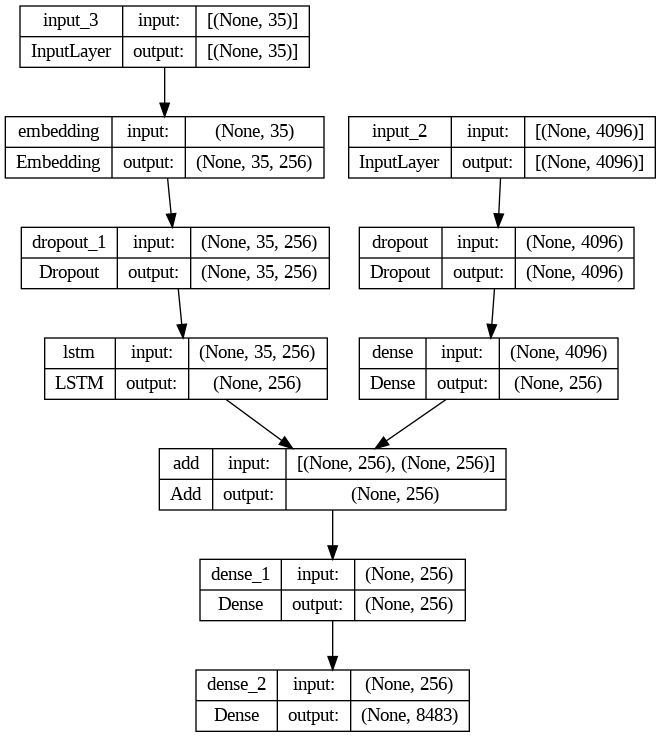

In [26]:
## MODEL CREATION

#image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation = 'relu')(fe1)

#text sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size , 256 ,mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#decoder model
decoder1 = add([fe2,se3])
decoder2 = Dense(256 , activation = 'relu')(decoder1)
outputs = Dense(vocab_size,activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1,inputs2] , outputs = outputs)
model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam')

#visualise
plot_model(model,show_shapes=True)



In [27]:
## MODEL TRAINING

epochs = 20
batch_size = 32
steps = len(train_data) // batch_size

for i in range(epochs):
  generator = data_generator(train_data , mapping , features , tokenizer , max_length , vocab_size , batch_size)
  model.fit(generator,epochs=1,steps_per_epoch = steps ,verbose=1)


227/227 [==============================] - 61s 270ms/step - loss: 2.1835


In [28]:
model.save(WORKING_DIR+'/caption_model.h5')

In [57]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [63]:
## Predicting the Caption

def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #print(sequence)
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        #sequence = sequence.reshape((1, sequence.shape[0]))
        #print(sequence)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        #print(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        #print(word)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'end':
            break

    return in_text

In [64]:
print(max_length)
#print(predict_caption(model,features['1002674143_1b742ab4b8'],tokenizer,max_length))

35


In [65]:
##Validation
from nltk.translate.bleu_score import corpus_bleu,SmoothingFunction
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_data):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    smooth = SmoothingFunction().method4

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0),smoothing_function=smooth))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0),smoothing_function=smooth))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.543036
BLEU-2: 0.316318


In [66]:
## Visualisation

from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
  img_path = os.path.join(BASE_DIR , "Images",image_name)
  img_id = image_name.split('.')[0]
  image = Image.open(img_path)
  captions = mapping[img_id]
  print("ACTUAL CAPTION")
  for caption in captions:
    print(caption)
  pred_caption = predict_caption(model,features[img_id],tokenizer,max_length)
  print("PREDICTED CAPTION")
  print(pred_caption)
  plt.imshow(image)


ACTUAL CAPTION
start black dog and spotted dog are fighting end
start black dog and tri-colored dog playing with each other on the road end
start black dog and white dog with brown spots are staring at each other in the street end
start two dogs of different breeds looking at each other on the road end
start two dogs on pavement moving toward each other end
PREDICTED CAPTION
start two dogs play with each other on the sidewalk end


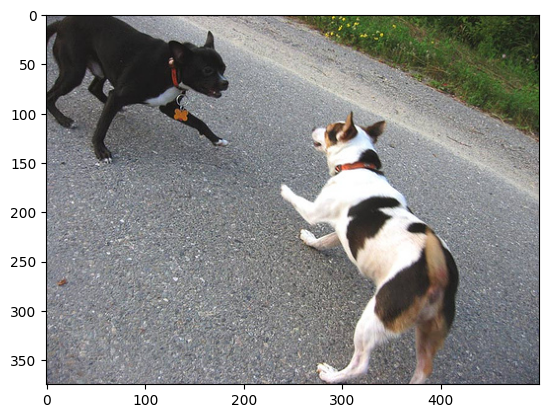

In [67]:
generate_caption('1001773457_577c3a7d70.jpg')

ACTUAL CAPTION
start boy smiles in front of stony wall in city end
start little boy is standing on the street while man in overalls is working on stone wall end
start young boy runs aross the street end
start young child is walking on stone paved street with metal pole and man behind him end
start smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him end
PREDICTED CAPTION
start woman in black shirt and overalls is standing in front of stony wall end


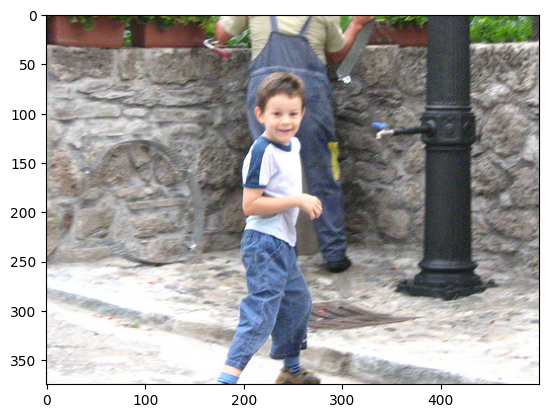

In [70]:
generate_caption('1015118661_980735411b.jpg')

ACTUAL CAPTION
start brown and white dog is running through the snow end
start dog is running in the snow end
start dog running through snow end
start white and brown dog is running through snow covered field end
start the white and brown dog is running over the surface of the snow end
PREDICTED CAPTION
start white dog with white patch and hind eye in his mouth is running through snow end


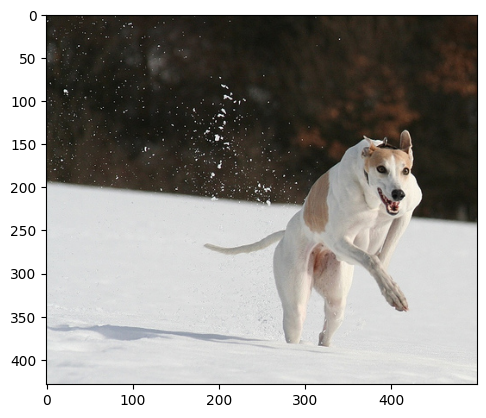

In [71]:
generate_caption('101654506_8eb26cfb60.jpg')